In [1]:
%matplotlib inline

import os
import time
import copy
import pickle
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import h5py
from tqdm.auto import tqdm, trange
import umap
from sampler import ImbalancedDatasetSampler
from ood_metrics import auroc, plot_roc, plot_barcode, calc_metrics, detection_error, fpr_at_95_tpr
import mc_uncertainty as mc

import torch
from torch.nn import functional as F
from torchvision import transforms
import torchvision.models as models
from torchvision.datasets import CIFAR10, CIFAR100, ImageFolder, SVHN
from torch import nn, optim
import torch.utils.data
import torchvision

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve


CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
FG_CLASSES = list(map(CIFAR10_CLASSES.index, 
                 ["cat"]))
BG_CLASSES = list(map(CIFAR10_CLASSES.index, 
                 ["airplane", "automobile", "bird", "deer", "frog", "dog", "horse", "ship", "truck"]))

NUM_CLASSES = 2
INPUT_SIZE = 224
# INPUT_SIZE = 32
BATCH_SIZE = 128
NUM_FEATURE_LAYERS = 31

RESULTS_FILE = 'cifar10_2class.h5'

TRAIN = False

In [2]:
def create_model(kind='resnet152'):
    # Download pretrained model
    if kind == 'resnet152':
        model = models.resnet152(pretrained=True)
    elif kind == "densenet161":
        model = models.densenet161(pretrained=True)
    elif kind == "vgg16":
        model = models.vgg16(pretrained=True)
        
    # Freeze weights
    for param in model.parameters():
        param.requires_grad = False

    # Re-implement final classification layer
    if kind == 'resnet152':
        model.fc = nn.Linear(in_features=model.fc.in_features, out_features=NUM_CLASSES, bias=True)
    elif kind == "densenet161":
        model.classifier = nn.Linear(in_features=model.classifier.in_features, out_features=NUM_CLASSES, bias=True)
    elif kind == "vgg16":
        model.classifier[6] = nn.Linear(in_features=model.classifier[6].in_features, out_features=NUM_CLASSES, bias=True)

    return model


class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    """

    def __init__(self, dataset, indices=None, num_samples=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices
            
        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        return dataset.target_transform(dataset.targets[idx])
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples
        


def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, lr_scheduler=None):
    since = time.time()

    train_acc_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in trange(num_epochs, desc="Epochs"):
        tqdm.write('Epoch {}/{}'.format(epoch, num_epochs - 1))
        tqdm.write('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], 
                                       total=len(dataloaders[phase]), 
                                       desc="{} batches".format(phase),
                                       leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            tqdm.write('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss = epoch_loss
                val_acc_history.append(epoch_acc)
            elif phase == 'train':
                train_acc_history.append(epoch_acc)
                
        if lr_scheduler is not None:
            lr_scheduler.step(val_loss)
            
        tqdm.write("\n")

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history


def save_model(model, path='model.pt'):
    torch.save(model.state_dict(), path)

    
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()


def plot_training_hist(train_hist, val_hist):
    thist = []
    vhist = []

    thist = [h.cpu().numpy() for h in train_hist]
    vhist = [h.cpu().numpy() for h in val_hist]

    plt.title("Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy")
    plt.plot(range(1,NUM_EPOCHS+1),thist,label="Train")
    plt.plot(range(1,NUM_EPOCHS+1),vhist,label="Val")
    plt.legend()
    plt.show()
    
    
def save_history(train_hist, val_hist, train_hist_path='train_hist.pickle', val_hist_path='val_hist.pickle'):
    with open(train_hist_path, 'wb') as f:
        pickle.dump(train_hist, f)
    with open(val_hist_path, 'wb') as f:
        pickle.dump(val_hist, f)
        
        
def load_history(train_hist_path='train_hist.pickle', val_hist_path='val_hist.pickle'):
    with open(train_hist_path, 'rb') as f:
        train_hist = pickle.load(f)
    with open(val_hist_path, 'rb') as f:
        val_hist = pickle.load(f)
    return train_hist, val_hist


def evaluate_model(model, dataloader):
    running_corrects = 0
    
    for inputs, labels in tqdm(dataloader, total=len(dataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

        # statistics
        running_corrects += torch.sum(preds == labels.data)

    accuracy = running_corrects.double() / len(dataloader.dataset)
    return accuracy.detach().cpu().item()

# Implement a pretrained classifer and finetuning for CIFAR 10

## Set up data loaders

Transform the training data as follows:
    - Remove all images with labels OOD_CLASSES
    - Change the labels:
        - 0: image is in FG_CLASSES (i.e it's a cat)
        - 1: image is one of BG_CLASSES (i.e. it's a airplane, automobile, bird, deer, dog, or frog)
        
Transform the test data as follows:
    - Change the labels:
        - 0: image is in FG_CLASSES (i.e it's a cat)
        - 1: image is one of BG_CLASSES (i.e. it's a airplane, automobile, bird, deer, dog, or frog)
        - 2: image is one of OOD_CLASSES (i.e. it's a horse, ship, or truck)

In [3]:
# Set up data loaders
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.RandomResizedCrop(INPUT_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

def label_transform(y):
    if y in FG_CLASSES: return 0
    elif y in BG_CLASSES: return 1
    else: return 2

cifar10_train = CIFAR10('/media/tadenoud/DATADisk/datasets/cifar10/', train=True, transform=data_transforms['train'], 
                        target_transform=label_transform)
cifar10_train_no_aug = CIFAR10('/media/tadenoud/DATADisk/datasets/cifar10/', train=True, transform=data_transforms['val'],
                               target_transform=label_transform)
cifar10_test = CIFAR10('/media/tadenoud/DATADisk/datasets/cifar10/', train=False, transform=data_transforms['val'], 
                       target_transform=label_transform)
cifar100_ood = CIFAR100('/media/tadenoud/DATADisk/datasets/cifar100/', train=False, transform=data_transforms['val'],
                       target_transform=lambda y: y+NUM_CLASSES)
imagenet_resize = ImageFolder('/media/tadenoud/DATADisk/datasets/tiny-imagenet-200/test', transform=data_transforms['val'],
                             target_transform=lambda y: y+NUM_CLASSES)
svhn_ood = SVHN('/media/tadenoud/DATADisk/datasets/svhn', split='test', transform=data_transforms['val'],
                target_transform=lambda y: y+NUM_CLASSES)


dataloaders_dict = {
    'train': torch.utils.data.DataLoader(cifar10_train, batch_size=BATCH_SIZE, 
                                         sampler=ImbalancedDatasetSampler(cifar10_train),
                                         num_workers=4, pin_memory=True),
    'train_no_aug': torch.utils.data.DataLoader(cifar10_train_no_aug, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(cifar10_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
    'ood': torch.utils.data.DataLoader(cifar100_ood, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
    'imagenet_resize': torch.utils.data.DataLoader(imagenet_resize, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
    'svhn': torch.utils.data.DataLoader(svhn_ood, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
model = create_model("vgg16")
model = model.to(device)

## Define optimization objective, optimizer, etc

In [5]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, patience=5)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


## Train and evaluate

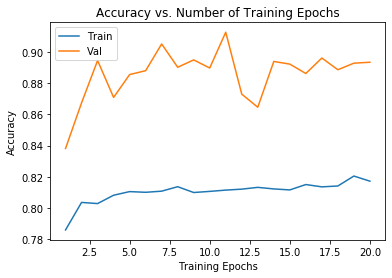

In [6]:
NUM_EPOCHS = 20
if TRAIN:
    # Train and evaluate
    model, val_hist, train_hist = train_model(
        model, 
        dataloaders_dict, 
        criterion, 
        optimizer_ft, 
        num_epochs=NUM_EPOCHS,
        lr_scheduler=scheduler_ft)
    save_model(model, path='vgg16_3.pt')
    save_history(train_hist, val_hist, 'train_hist_3.pickle', 'val_hist_3.pickle')
else:
    load_model(model, path='vgg16_3.pt')
    train_hist, val_hist = load_history('train_hist_3.pickle', 'val_hist_3.pickle')

plot_training_hist(train_hist, val_hist)    

## Fine tune top convolutional layers

In [7]:
# print(model)

# Freeze weights
for param in model.parameters():
    param.requires_grad = False
    
# Unfreeze top layers
for param in model.features[23:].parameters():
    param.requires_grad = True
    
for param in model.classifier.parameters():
    param.requires_grad = True

In [8]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=1e-3, momentum=0.9)
scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, patience=5)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 features.24.weight
	 features.24.bias
	 features.26.weight
	 features.26.bias
	 features.28.weight
	 features.28.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


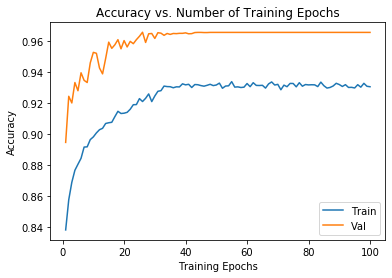

In [9]:
NUM_EPOCHS = 100
if TRAIN:
    # Train and evaluate
    model, val_hist, train_hist = train_model(model, 
                                              dataloaders_dict, 
                                              criterion, 
                                              optimizer_ft, 
                                              num_epochs=NUM_EPOCHS,
                                              lr_scheduler=scheduler_ft)
    save_model(model, path='vgg16_fine_3.pt')
    save_history(train_hist, val_hist, 'train_hist_fine_3.pickle', 'val_hist_fine_3.pickle')
    
else:
    load_model(model, path='vgg16_fine_3.pt')
    train_hist, val_hist = load_history('train_hist_fine_3.pickle', 'val_hist_fine_3.pickle')

plot_training_hist(train_hist, val_hist)

In [10]:
# print("Model accuracy:", evaluate_model(model, dataloaders_dict['val'])) 

# Train Mahalanobis Distance function

In [11]:
def penultimate_forward_densenet161(self, x):
    features = self.features(x)
    out = F.relu(features, inplace=True)
    penultimate = F.avg_pool2d(out, kernel_size=7, stride=1).view(features.size(0), -1)
    out = self.classifier(penultimate)
    return out, penultimate

def penultimate_forward_vgg16(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    
    # Break up self.classifier
    penultimate = model.classifier[:5](x)
    out = model.classifier[5:](penultimate)
    return out, penultimate

# Bind a function to the model to extract penultimate features
model.penultimate_forward = penultimate_forward_vgg16.__get__(model)

In [13]:
# Get penultimate features, outputs, and labels from datasets set
if TRAIN:
    model.eval()
    
    for dataset in ['train_no_aug', 'val', 'ood', 'svhn']:
        softmax_outputs = []
        mahalanobis_features = []
        labels_out = []  
        
        for inputs, labels in tqdm(dataloaders_dict[dataset], total=len(dataloaders_dict[dataset]), desc=dataset):
            outputs, features = model.penultimate_forward(inputs.to(device))

            softmax_outputs.append(outputs.cpu().detach().numpy())
            mahalanobis_features.append(features.cpu().detach().numpy())
            labels_out.append(labels.cpu().detach().numpy())

        # Save outputs to disk
        with h5py.File(RESULTS_FILE, "a") as f:
            if dataset in f.keys():
                del f[dataset]
                
            g = f.create_group(dataset)
            g.create_dataset("softmax_outputs", data=np.concatenate(softmax_outputs, axis=0))
            g.create_dataset("mahalanobis_features", data=np.concatenate(mahalanobis_features, axis=0))
            g.create_dataset("labels", data=np.concatenate(labels_out, axis=0))

In [14]:
class Mahal_Dist(object):
    def __init__(self, gt_features=None, gt_labels=None):
        super().__init__()
        
        if gt_features is not None and gt_labels is not None:
            self.fit(gt_features, gt_labels)
        
    def fit(self, gt_features, gt_labels):
        """Fit parameters used for Mahalanobis distance."""
        self.labels = sorted(np.unique(gt_labels).astype(np.int))
        
        mahal_means = []
        print("Calculating mahal mean")
        for l in self.labels:
            mask = gt_labels == l
            mahal_means.append(gt_features[mask].mean(axis=0))#, dtype=np.float16))
            
        self.mahal_means = np.array(mahal_means)

        x = gt_features.copy()
        print("Calculating mahal cov")
        for i, l in enumerate(self.labels):
            mask = gt_labels == l
            x[mask] -= self.mahal_means[i]

        self.mahal_cov = np.dot(x.T, x) / len(gt_features)
        print("Inverting")
        self.inv_mahal_cov = np.linalg.inv(self.mahal_cov + np.eye(len(self.mahal_cov)) * 1e-10)
        
    def __call__(self, features):
        """Return the distance based confidence score to each 
            of the means."""
        x =  -self.mahal_means + features
        m_x = np.diag(-np.dot(np.dot(x, self.inv_mahal_cov), x.T))
        return np.array(m_x)
    
    def label_dist(self, features):
        """Return the label of the closest mean and the 
            mahalanobis distance to it."""
        m_x = self(features)
        max_i = np.argmax(m_x, axis=0)
        return np.array([self.labels[max_i], m_x[max_i]])
    
    def label(self, features):
        """Return the label of the closest mean."""
        return self.labels[np.argmax(self(features), axis=0)]
    
    def dist(self, features):
        """Return the dist of the closest mean."""
        return np.max(self(features), axis=0)
    
    def save(self, fname='mahal_distance.h5'):
        """Save precomputed Mahal_Dist object with all means and covariance matrix."""
        with h5py.File(fname, 'a') as f:
            # Remove old data if exists
            if "mahal_distance" in f.keys():
                del f['mahal_distance']
                
            # Store the new data
            g = f.create_group("mahal_distance")
            g.create_dataset("means", data=self.mahal_means)
            g.create_dataset("cov", data=self.mahal_cov)
            g.create_dataset("inv_cov", data=self.inv_mahal_cov)
            g.create_dataset("labels", data=self.inv_mahal_cov)
            
    @classmethod
    def load(cls, fname='mahal_distance.h5'):
        """Load precomputed Mahal_Dist object with all means and covariance matrix."""
        inst = cls()
        
        with h5py.File(fname, 'r') as f:
            inst.labels = f['mahal_distance/labels'].value
            inst.mahal_means = f['mahal_distance/means'].value
            inst.mahal_cov = f['mahal_distance/cov'].value
            inst.inv_mahal_cov = f['mahal_distance/inv_cov'].value
        
        return inst

In [18]:
if TRAIN:  
    with h5py.File(RESULTS_FILE, "r") as f:
        mahalanobis_features_train = f['train_no_aug/mahalanobis_features'].value
        labels_train = f['train_no_aug/labels'].value
    
    md = Mahal_Dist()
    md.fit(mahalanobis_features_train, labels_train)
    md.save(RESULTS_FILE)
else:
    md = Mahal_Dist.load(RESULTS_FILE)

Calculating mahal mean
Calculating mahal cov
Inverting


# Extract FG, BG, OOD Softmax predictions and Mahal features

In [22]:
if TRAIN:
    for dataset in ['val', 'ood', 'svhn']:
        print(dataset)
        with h5py.File(RESULTS_FILE, 'r') as f:
            g = f[dataset]
            labels = g['labels'][()]
            features = g['mahalanobis_features'][()]
            outputs = g['softmax_outputs'][()]    
        
        mahalanobis_label_dist = list(map(md.label_dist, features))

        # Get gt_labels, predicted labels, distance to nearest mean
        mahalanobis_labels = [x[0] for x in mahalanobis_label_dist]
        mahalanobis_dist = [x[1] for x in mahalanobis_label_dist]

        with h5py.File(RESULTS_FILE, 'a') as f:
            g = f[dataset]          
            g.create_dataset('mahalanobis_labels', data=mahalanobis_labels)
            g.create_dataset('mahalanobis_dists', data=mahalanobis_dist)    

ood
svhn


In [23]:
with h5py.File(RESULTS_FILE, 'r') as f:
    g = f['val']
    labels_val = g['labels'][()]
    mahalanobis_labels_val = g['mahalanobis_labels'][()]
    mahalanobis_dist_val = g['mahalanobis_dists'][()]

correct = np.sum((mahalanobis_labels_val == labels_val).astype(np.int))
print("%d%% of val data classified correctly with mahalanobis distance" % (correct / len(labels_val) * 100))

96% of val data classified correctly with mahalanobis distance


# Extract FG, BG, OOD MC dropout Softmax scores

In [37]:
# Setup model for dropout
model.eval()

# Set all dropout layers to train mode
def mc_dropout(m):
    if type(m) == nn.Dropout:
        print(m)
        m.train()

model.apply(mc_dropout);

Dropout(p=0.5)
Dropout(p=0.5)


In [38]:
NUM_MC_DROPOUT_RUNS = 50

if TRAIN:
    for dataset in ['val', 'ood', 'svhn']:
        mc_softmax_outputs = [np.empty((0,NUM_CLASSES))] * NUM_MC_DROPOUT_RUNS

        for x, y in tqdm(dataloaders_dict[dataset], total=len(dataloaders_dict[dataset]), desc=dataset):
            for i in trange(NUM_MC_DROPOUT_RUNS, leave=False):
                output = model(x.cuda())
                softmax_out = F.softmax(output, dim=1)
                softmax_out = softmax_out.detach().cpu().numpy()
                mc_softmax_outputs[i] = np.concatenate((mc_softmax_outputs[i], softmax_out), axis=0)

        mc_softmax_outputs = np.array(mc_softmax_outputs)

        with h5py.File(RESULTS_FILE, 'a') as f:
            g = f[dataset]
            g.create_dataset('mc_outputs', data=mc_softmax_outputs)

# Using Vahdats SVM method

### Add methods to model to get features

In [39]:
def early_features_forward_vgg16(self, x, layer):
    features = self.features[:layer+1](x)
    x = self.features[layer+1:](features)
    features = torch.mean(features, (2, 3))
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    
    # Break up self.classifier
    out = model.classifier(x)
    return out, features

# Bind a function to the model to extract penultimate features
model.early_features_forward = early_features_forward_vgg16.__get__(model)

In [40]:
def extract_all_features_vgg16(self, x, savefile, group):
    with h5py.File(savefile, "a") as f:
        if not group in f.keys():
            f.create_group(group)
        g = f[group]
        
        if not "svm" in g.keys():
            g.create_group("svm")
        g = g["svm"]
        
        for i, layer in enumerate(self.features):
            x = layer(x)
            
            # Save the features
            
            features = torch.mean(x, (2, 3))
            datasetname = "layer_{}".format(i)
            if not datasetname in g.keys():
                dts = g.create_dataset(datasetname, maxshape=(None, *features.shape[1:]), chunks=True, 
                                       data=features.cpu().detach().numpy())
                
            else:
                dts = g[datasetname]
                dts.resize((dts.shape[0] + features.shape[0]), axis=0)
                dts[-features.shape[0]:] = features.cpu().detach().numpy()

    x = x.view(x.size(0), -1)
    return model.classifier(x)

# Bind a function to the model to extract penultimate features
model.extract_all_features = extract_all_features_vgg16.__get__(model)

### Get features for all datasets

In [41]:
# Get penultimate features, outputs, and labels from datasets set
if TRAIN:
    model.eval()
    
    for dataset in ['train_no_aug', 'val', 'imagenet_resize', 'ood', 'svhn']:
        # Delete any old results (may also require h5repack)
        with h5py.File(RESULTS_FILE, 'a') as f:
            g = f[dataset]
            if "svm" in g.keys():
                del g["svm"]
        
        # Extract all the features
        for inputs, labels in tqdm(dataloaders_dict[dataset], total=len(dataloaders_dict[dataset]), desc="{}".format(dataset)):
            _ = model.extract_all_features(inputs.to(device), RESULTS_FILE, dataset)
        

### Train an SVM model for each feature layer

In [42]:
# For each layer in model, train One-class SVM on val data
if TRAIN:
    for layer in trange(NUM_FEATURE_LAYERS): 
        dataname = "layer_{}".format(layer)

        # Load the dataset
        with h5py.File(RESULTS_FILE, 'r') as f:
            g = f['train_no_aug/svm']
            dts = g[dataname][()]
    
        # Build a standard scaling one class svm model
        scaler_model = StandardScaler()
        svm_model = OneClassSVM(kernel='rbf', nu=0.001, gamma='scale')
        
        scale_svm_model = Pipeline((["ss", scaler_model], ["svm", svm_model]))    
        scale_svm_model.fit(dts)
        
        # Save model params
        with open('svm_model_{}.pickle'.format(dataname), 'wb') as f:
            pickle.dump(scale_svm_model, f)

/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)
/home/tadenoud/anaconda3/envs/nn/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWar

### Find the optimal SVM model/layer

layer_0 (20000, 64) err: 0.46625
layer_1 (20000, 64) err: 0.1543
layer_2 (20000, 64) err: 0.14790000000000003
layer_3 (20000, 64) err: 0.014299999999999976
layer_4 (20000, 64) err: 0.014999999999999975
layer_5 (20000, 128) err: 0.02510000000000002
layer_6 (20000, 128) err: 0.024999999999999977
layer_7 (20000, 128) err: 0.013099999999999994
layer_8 (20000, 128) err: 0.0064999999999999745
layer_9 (20000, 128) err: 0.004549999999999991
layer_10 (20000, 256) err: 0.003850000000000001
layer_11 (20000, 256) err: 0.004849999999999974
layer_12 (20000, 256) err: 0.007000000000000013
layer_13 (20000, 256) err: 0.0025999999999999734
layer_14 (20000, 256) err: 0.01265000000000002
layer_15 (20000, 256) err: 0.0018500000000000224
layer_16 (20000, 256) err: 0.0018499999999999725
layer_17 (20000, 512) err: 0.013799999999999972
layer_18 (20000, 512) err: 0.006899999999999997
layer_19 (20000, 512) err: 0.017999999999999978
layer_20 (20000, 512) err: 0.009549999999999982
layer_21 (20000, 512) err: 0.0309

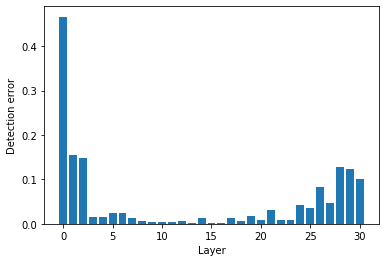

Best layer: 16


In [43]:
# Calculate the detection error with the imagenet data and find lowest detection err
errors = []
for layer in trange(NUM_FEATURE_LAYERS): 
    dataname = "layer_{}".format(layer)

    # Load SVM model
    with open('svm_model_{}.pickle'.format(dataname), 'rb') as f:
        scale_svm_model = pickle.load(f)

    # Load the datasets
    with h5py.File(RESULTS_FILE, 'r') as f:
        g = f['val/svm']
        dts_id = g[dataname][()]

        g = f['imagenet_resize/svm']
        dts_ood = g[dataname][()]

        dts = np.concatenate((dts_id, dts_ood), axis=0)

    # Calculate detection error
    # Score the data
    scores = scale_svm_model.decision_function(dts)
    labels = np.concatenate((np.ones(len(dts_id)), np.zeros(len(dts_ood))))
    err = detection_error(scores, labels)
    tqdm.write("%s %s err: %s" % (dataname, str(dts.shape), err))
    errors.append(err)

plt.bar(range(NUM_FEATURE_LAYERS), errors)
plt.ylabel("Detection error")
plt.xlabel("Layer")
plt.show()
best_layer = np.array(errors).argmin()
print("Best layer:", best_layer)

### Save SVM scores for the ID and OOD datasets

In [44]:
if TRAIN:
    best_layer = np.array(errors).argmin()
    print("Best layer:", best_layer)

    dataname = "layer_{}".format(best_layer)

    # Test outlier detection performance on inliers and validata
    with open('svm_model_{}.pickle'.format(dataname), 'rb') as f:
        scale_svm_model = pickle.load(f)
    
    for dataset in ['val', 'ood', 'svhn']:
        # Load the datasets
        with h5py.File(RESULTS_FILE, 'r') as f:
            g = f[dataset]['svm']
            dts = g[dataname][()]

        # Save the predictions
        with h5py.File(RESULTS_FILE, 'a') as f:
            g = f[dataset]
            if 'svm_scores' in g.keys():
                del g['svm_scores']
            scores = scale_svm_model.decision_function(dts)
            g.create_dataset('svm_scores', data=scores)

Best layer: 16


# Separating BG+FG from OOD

In [47]:
# Load all the data
# OOD_DATASET = 'ood'
OOD_DATASET = 'svhn'

with h5py.File(RESULTS_FILE, 'r') as f:
    labels_val = f['val/labels'][()]
    labels_ood = f[f'{OOD_DATASET}/labels'][()]
    labels = np.concatenate([labels_val, labels_ood], axis=0)
    
    mahalanobis_dist_val = f['val/mahalanobis_dists'][()]
    mahalanobis_dist_ood = f[f'{OOD_DATASET}/mahalanobis_dists'][()]
    mahalanobis_dist = np.concatenate([mahalanobis_dist_val, mahalanobis_dist_ood], axis=0)
    
    softmax_outputs_val = f['val/softmax_outputs'][()]
    softmax_outputs_ood = f[f'{OOD_DATASET}/softmax_outputs'][()]
    softmax_outputs = np.concatenate([softmax_outputs_val, softmax_outputs_ood], axis=0)
    
    mc_softmax_outputs_val = f['val/mc_outputs'][()]
    mc_softmax_outputs_ood = f[f'{OOD_DATASET}/mc_outputs'][()]
    mc_softmax_outputs = np.concatenate([mc_softmax_outputs_val, mc_softmax_outputs_ood], axis=1)
    
    svm_scores_val = f['val/svm_scores'][()]
    svm_scores_ood = f[f'{OOD_DATASET}/svm_scores'][()]
    svm_scores = np.concatenate([svm_scores_val, svm_scores_ood], axis=0)

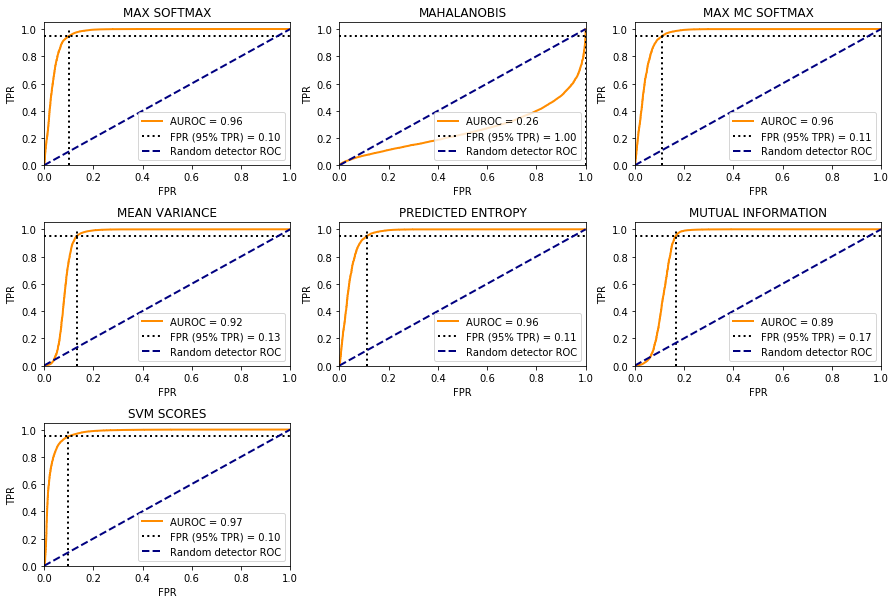

In [48]:
from collections import OrderedDict

scores_dict = OrderedDict({
    "max_softmax": -softmax_outputs.max(axis=1),
    "mahalanobis": -np.array(mahalanobis_dist),
    "max_mc_softmax": -np.max(np.mean(mc_softmax_outputs, axis=0), axis=1),
    "mean_variance": np.mean(mc.variance(mc_softmax_outputs), axis=1),
    "predicted_entropy": mc.predicted_entropy(mc_softmax_outputs),
    "mutual_information": mc.mutual_information(mc_softmax_outputs),
    "svm_scores": -svm_scores
})

plt.figure(figsize=(15,10))

for i, (sk, sv) in enumerate(scores_dict.items()):
    ood_labels = (labels >= NUM_CLASSES).astype(np.int)
    
    fpr, tpr, _ = roc_curve(ood_labels, sv)
    tpr95 = fpr_at_95_tpr(sv, ood_labels)
    roc_auc = auroc(sv, ood_labels)

    plt.subplot(331+i)

    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='AUROC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0.95, 0.95], color='black', lw=lw, linestyle=':', label='FPR (95%% TPR) = %0.2f' % tpr95)
    plt.plot([tpr95, tpr95], [0, 1], color='black', lw=lw, linestyle=':')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random detector ROC')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(sk.replace("_", " ").upper())
    plt.legend(loc="lower right")

plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

In [ ]:
class InputPerturbation(nn.Module):
    def __init__(self, model):
        super().__init__()
        
    

# Separating FG from OOD

In [50]:
# mahalanobis_predicted_distances = list(map(md, id_conv_feats)) + list(map(md, ood_conv_feats))

# mahalanobis_predicted_dist_from_fg = np.array(mahalanobis_predicted_distances)[0,:]
# mahalanobis_predicted_dist_from_bg = np.array(mahalanobis_predicted_distances)[1,:]

fg_pred_mask = softmax_outputs.argmax(axis=1).astype(np.bool)

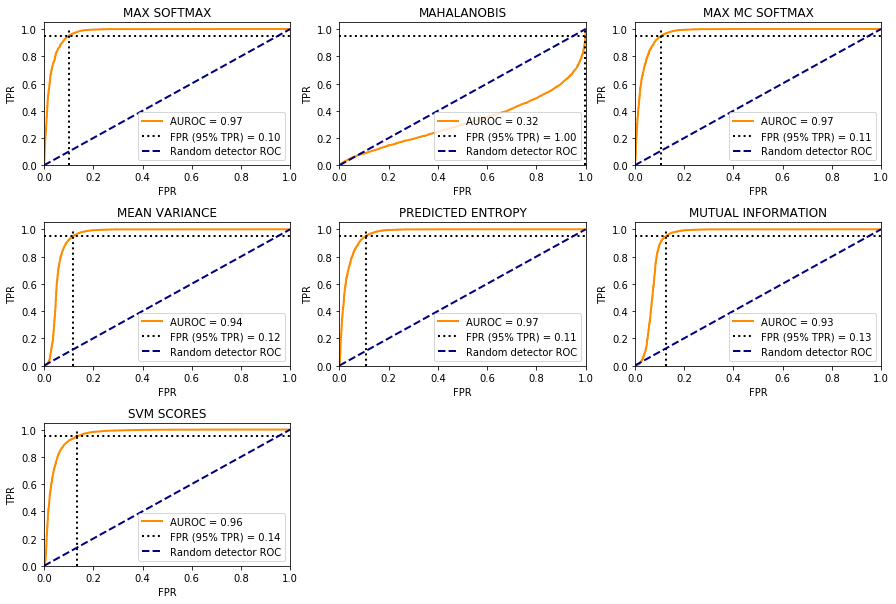

In [51]:
plt.figure(figsize=(15,10))

for i, (sk, sv) in enumerate(scores_dict.items()):
    ood_labels = (labels).astype(np.int)
    
    sv = np.array(sv)[fg_pred_mask]
    lv = ood_labels[fg_pred_mask] >= NUM_CLASSES
    
    fpr, tpr, _ = roc_curve(lv, sv)
    tpr95 = fpr_at_95_tpr(sv, lv)
    roc_auc = auroc(sv, lv)

    plt.subplot(331+i)

    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='AUROC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0.95, 0.95], color='black', lw=lw, linestyle=':', label='FPR (95%% TPR) = %0.2f' % tpr95)
    plt.plot([tpr95, tpr95], [0, 1], color='black', lw=lw, linestyle=':')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random detector ROC')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(sk.replace("_", " ").upper())
    plt.legend(loc="lower right")

plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

# Separating BG from OOD

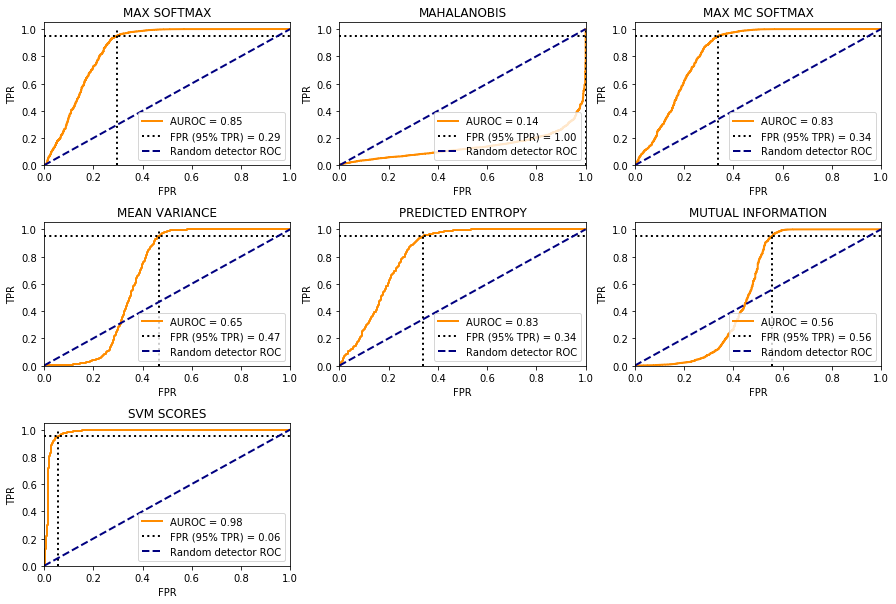

In [40]:
plt.figure(figsize=(15,10))

for i, (sk, sv) in enumerate(scores_dict.items()):
    ood_labels = (labels).astype(np.int)
    sv = np.array(sv)[~fg_pred_mask]
    lv = ood_labels[~fg_pred_mask] >= NUM_CLASSES
    
    fpr, tpr, _ = roc_curve(lv, sv)
    tpr95 = fpr_at_95_tpr(sv, lv)
    roc_auc = auroc(sv, lv)

    plt.subplot(331+i)

    lw = 2
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='AUROC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0.95, 0.95], color='black', lw=lw, linestyle=':', label='FPR (95%% TPR) = %0.2f' % tpr95)
    plt.plot([tpr95, tpr95], [0, 1], color='black', lw=lw, linestyle=':')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random detector ROC')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title(sk.replace("_", " ").upper())
    plt.legend(loc="lower right")

plt.subplots_adjust(wspace=0.2, hspace=0.4)
plt.show()

# Visualizations

## Visual separability of classes using logits

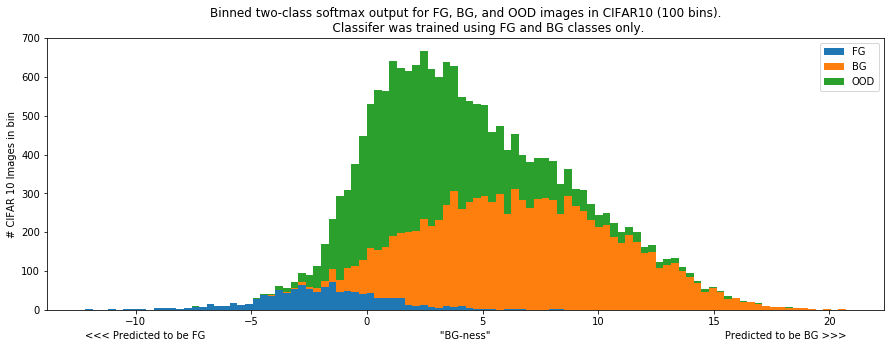

In [84]:
plt.figure(figsize=(15, 5))

fg_points = softmax_outputs[labels == 0][:,1]
bg_points = softmax_outputs[labels == 1][:,1]
ood_points = softmax_outputs[labels >= 2][:,1]

# fg_points = F.softmax(torch.Tensor(softmax_outputs[labels == 0])).numpy()[:,1]
# bg_points = F.softmax(torch.Tensor(softmax_outputs[labels == 1])).numpy()[:,1]
# ood_points = F.softmax(torch.Tensor(softmax_outputs[labels >= 2])).numpy()[:,1]

plt.hist((fg_points, bg_points, ood_points), bins=100, stacked=True, log=False, label=["FG", "BG", "OOD"])
plt.xlabel('<<< Predicted to be FG' + " "*75 + "\"BG-ness\"" + " "*75 + 'Predicted to be BG >>>')
plt.ylabel('# CIFAR 10 Images in bin')
plt.title("""Binned two-class softmax output for FG, BG, and OOD images in CIFAR10 (100 bins).
            Classifer was trained using FG and BG classes only.""")
plt.legend()
plt.show()

## Penultimate feature space

### UMAP Visualization

In [96]:
# from MulticoreTSNE import MulticoreTSNE as TSNE

# embedding = TSNE(n_jobs=4).fit_transform(conv_feats.reshape(conv_feats.shape[0], -1))

embedding = umap.UMAP().fit_transform(mahalanobis_features)

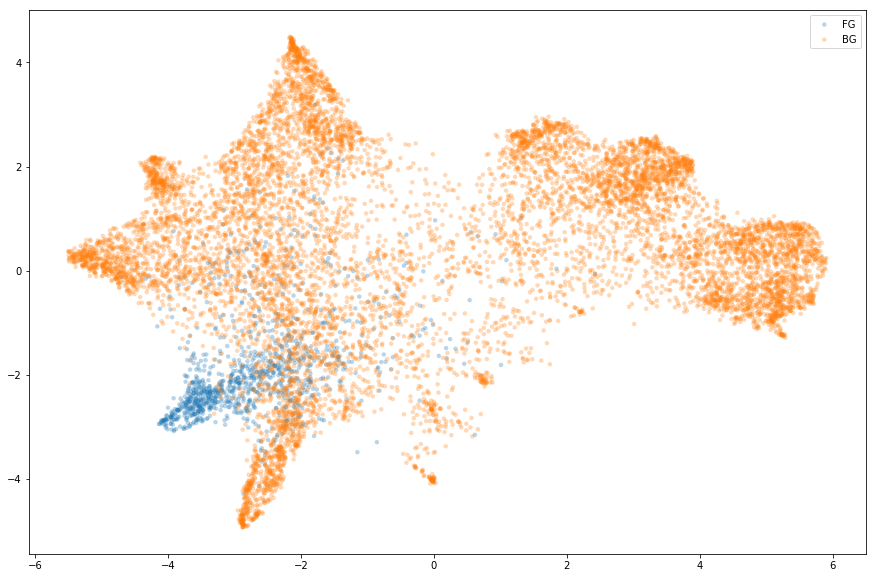

In [100]:
fig, ax = plt.subplots(figsize=(15, 10))
text_labels = ['FG', 'BG']

for label in range(len(text_labels)):
    x = embedding[:,0][labels == label]
    y = embedding[:,1][labels == label]
    ax.scatter(x, y, c=colors[label], s=20, label=text_labels[label], alpha=0.3, edgecolors='none')

ax.legend()
plt.show()

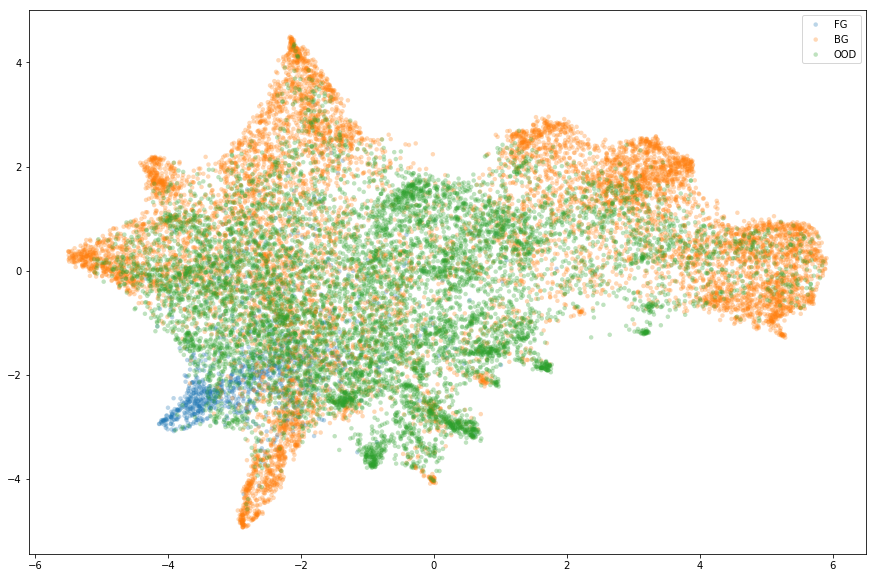

In [101]:
fig, ax = plt.subplots(figsize=(15, 10))
text_labels = ['FG', 'BG', 'OOD']

for label in range(len(text_labels)):
    x = embedding[:,0][labels == label]
    y = embedding[:,1][labels == label]
    ax.scatter(x, y, c=colors[label], s=20, label=text_labels[label], alpha=0.3, edgecolors='none')

ax.legend()
plt.show()

# Break down above plots by CIFAR 100 superclass

In [20]:
from collections import OrderedDict

cifar100_labels = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 
    'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 
    'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 
    'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 
    'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 
    'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 
    'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]
   
cifar100_superclasses = {
    "aquatic mammals": ["beaver", "dolphin", "otter", "seal", "whale"],
    "fish": ["aquarium_fish", "flatfish", "ray", "shark", "trout"],
    "flowers": ["orchid", "poppy", "rose", "sunflower", "tulip"],
    "food containers": ["bottle", "bowl", "can", "cup", "plate"],
    "fruit and vegetables": ["apple", "mushroom", "orange", "pear", "sweet_pepper"],
    "household electrical devices": ["clock", "keyboard", "lamp", "telephone", "television"],
    "household furniture": ["bed", "chair", "couch", "table", "wardrobe"],
    "insects": ["bee", "beetle", "butterfly", "caterpillar", "cockroach"],
    "large carnivores": ["bear", "leopard", "lion", "tiger", "wolf"],
    "large man-made outdoor things": ["bridge", "castle", "house", "road", "skyscraper"],
    "large natural outdoor scenes": ["cloud", "forest", "mountain", "plain", "sea"],
    "large omnivores and herbivores": ["camel", "cattle", "chimpanzee", "elephant", "kangaroo"],
    "medium-sized mammals": ["fox", "porcupine", "possum", "raccoon", "skunk"],
    "non-insect invertebrates": ["crab", "lobster", "snail", "spider", "worm"],
    "people": ["baby", "boy", "girl", "man", "woman"],
    "reptiles": ["crocodile", "dinosaur", "lizard", "snake", "turtle"],
    "small mammals": ["hamster", "mouse", "rabbit", "shrew", "squirrel"],
    "trees": ["maple_tree", "oak_tree", "palm_tree", "pine_tree", "willow_tree"],
    "vehicles 1": ["bicycle", "bus", "motorcycle", "pickup_truck", "train"],
    "vehicles 2": ["lawn_mower", "rocket", "streetcar", "tank", "tractor"]
}
cifar100_superclasses = OrderedDict(sorted(cifar100_superclasses.items(), key=lambda t: t[0]))
reverse_superclasses = dict()
for i, (k, vs) in enumerate(cifar100_superclasses.items()):
    for v in vs:
        reverse_superclasses[v] = i
    
def cifar100_superclass_label_transform(y):
    return reverse_superclasses[cifar100_labels[y]] + 2

cifar100_superclass_dataset = CIFAR100('/media/tadenoud/DATADisk/datasets/cifar100/', train=False, 
                                 transform=data_transforms['val'], 
                                 target_transform=cifar100_superclass_label_transform)

dataloaders_dict['superclasses_ood'] = torch.utils.data.DataLoader(cifar100_superclass_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [21]:
from torch.nn import functional as F

softmax_outputs = np.empty((0,2))
test_labels = np.empty((0,))

# Inlier FG and BG
for x, y in tqdm(dataloaders_dict['val'], total=len(dataloaders_dict['val'])):
    output = model(x.cuda())
    softmax_out = F.softmax(output, dim=1)
    softmax_out = softmax_out.detach().cpu().numpy()
    softmax_outputs = np.concatenate((softmax_outputs, softmax_out), axis=0)
    test_labels = np.concatenate((test_labels, y.detach().cpu().numpy()), axis=0) 
    
# Outliers OOD  
for x, y in tqdm(dataloaders_dict['superclasses_ood'], total=len(dataloaders_dict['ood'])):
    output = model(x.cuda())
    softmax_out = F.softmax(output, dim=1)
    softmax_out = softmax_out.detach().cpu().numpy()
    softmax_outputs = np.concatenate((softmax_outputs, softmax_out), axis=0)
    test_labels = np.concatenate((test_labels, y.detach().cpu().numpy()), axis=0)    

In [22]:
list(cifar100_superclasses.keys())

['aquatic mammals',
 'fish',
 'flowers',
 'food containers',
 'fruit and vegetables',
 'household electrical devices',
 'household furniture',
 'insects',
 'large carnivores',
 'large man-made outdoor things',
 'large natural outdoor scenes',
 'large omnivores and herbivores',
 'medium-sized mammals',
 'non-insect invertebrates',
 'people',
 'reptiles',
 'small mammals',
 'trees',
 'vehicles 1',
 'vehicles 2']

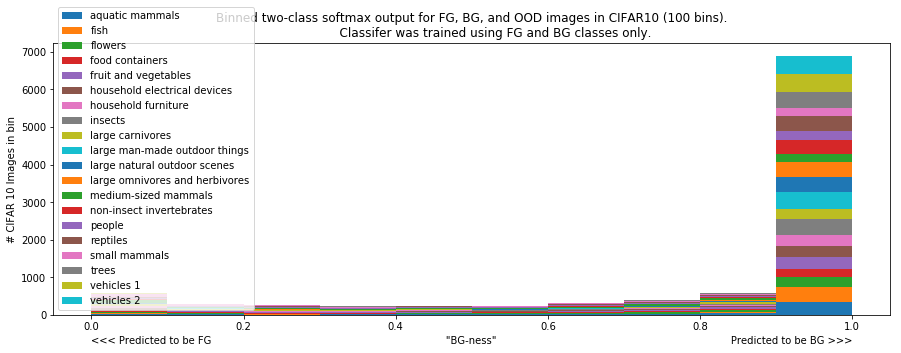

In [23]:
plt.figure(figsize=(15, 5))

ood_points = [softmax_outputs[:,1][test_labels == i + 2] for i in range(len(cifar100_superclasses.keys()))]

plt.hist(ood_points, bins=10, stacked=True, log=False, label=list(cifar100_superclasses.keys()))
plt.xlabel('<<< Predicted to be FG' + " "*75 + "\"BG-ness\"" + " "*75 + 'Predicted to be BG >>>')
plt.ylabel('# CIFAR 10 Images in bin')
plt.title("""Binned two-class softmax output for FG, BG, and OOD images in CIFAR10 (100 bins).
            Classifer was trained using FG and BG classes only.""")
plt.legend()
plt.show()

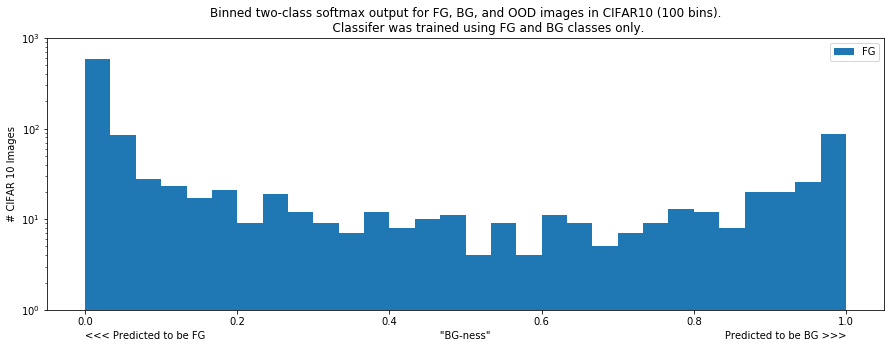

In [24]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

plt.figure(figsize=(15, 5))

plt.hist(fg_points, bins=30, color=colors[0], log=True, label=["FG"])
plt.xlabel('<<< Predicted to be FG' + " "*75 + "\"BG-ness\"" + " "*75 + 'Predicted to be BG >>>')
plt.ylabel('# CIFAR 10 Images')
plt.title("""Binned two-class softmax output for FG, BG, and OOD images in CIFAR10 (100 bins).
            Classifer was trained using FG and BG classes only.""")
plt.yticks([10**x for x in range(4)])
plt.legend()
plt.show()

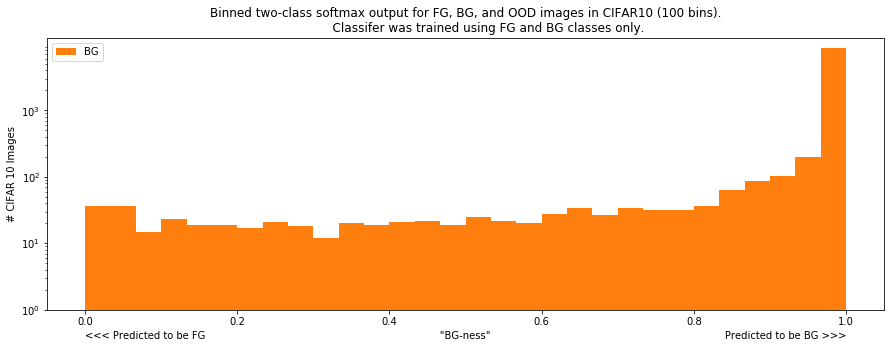

In [25]:
plt.figure(figsize=(15, 5))

plt.hist(bg_points, bins=30, color=colors[1], log=True, label=["BG"])
plt.xlabel('<<< Predicted to be FG' + " "*75 + "\"BG-ness\"" + " "*75 + 'Predicted to be BG >>>')
plt.ylabel('# CIFAR 10 Images')
plt.title("""Binned two-class softmax output for FG, BG, and OOD images in CIFAR10 (100 bins).
            Classifer was trained using FG and BG classes only.""")
plt.yticks([10**x for x in range(4)])
plt.legend()
plt.show()

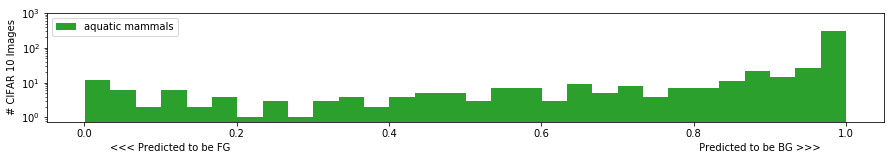

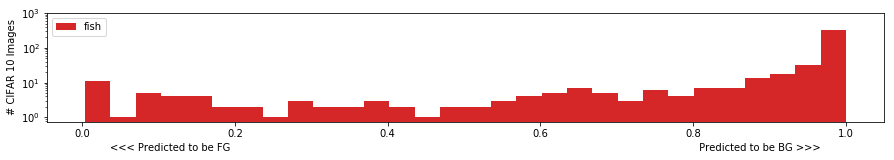

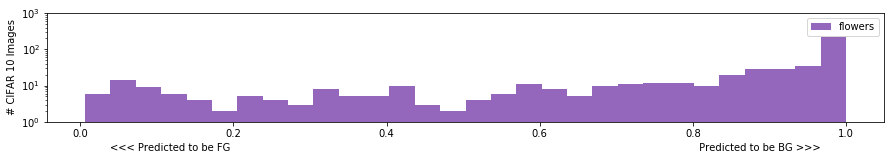

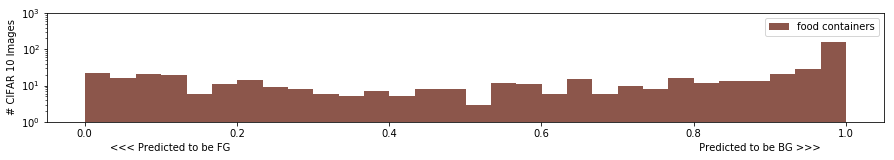

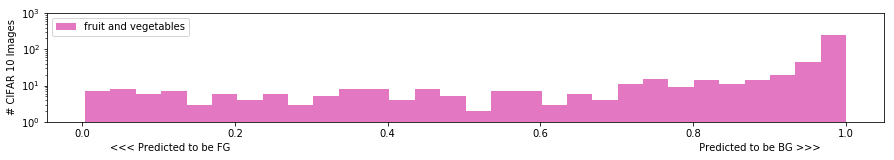

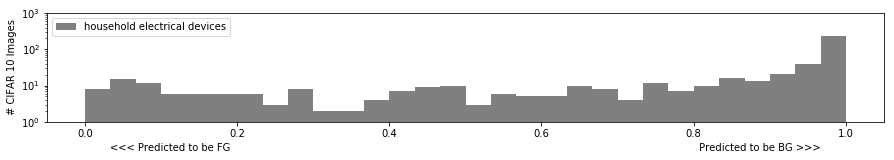

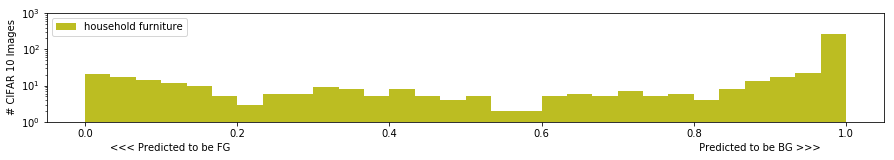

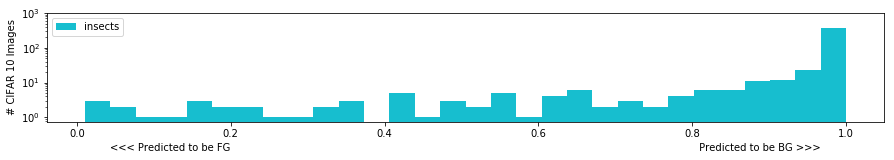

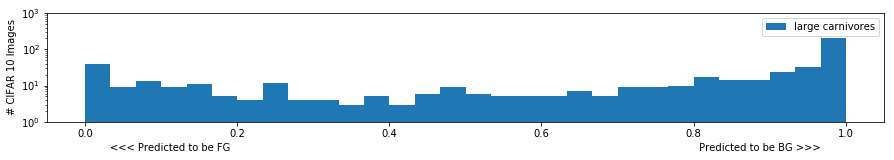

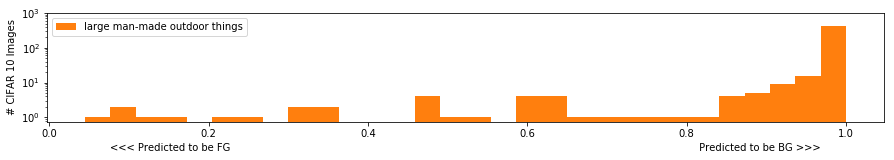

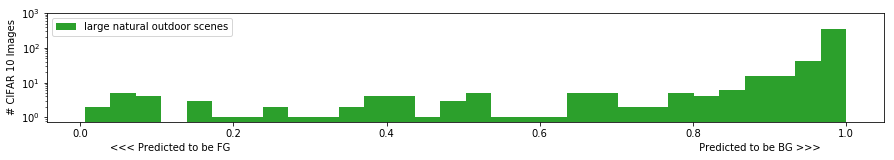

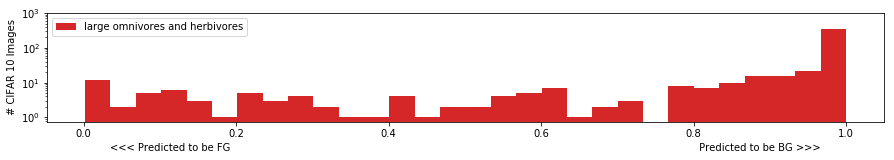

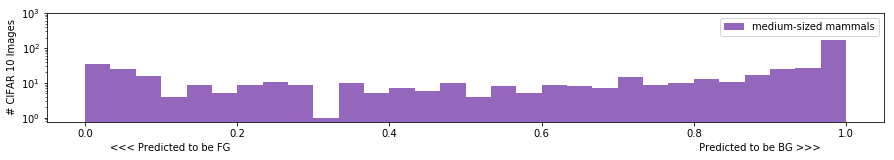

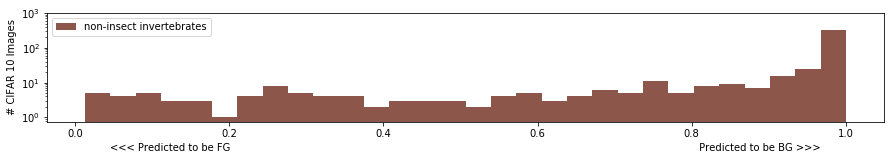

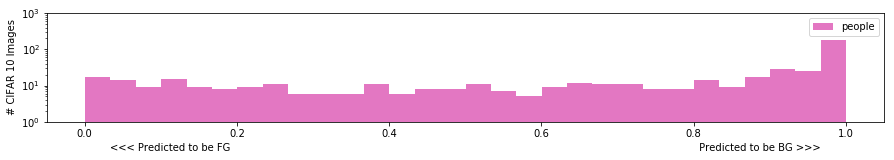

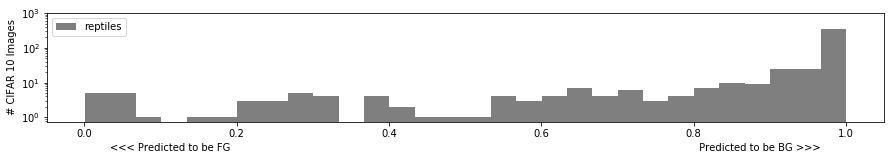

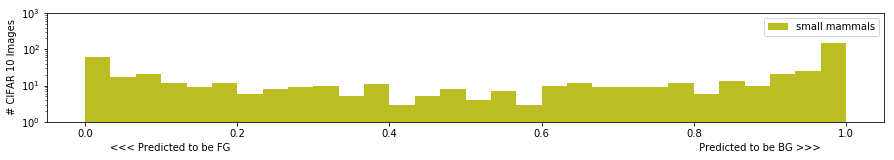

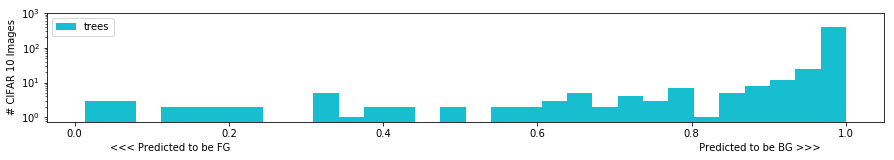

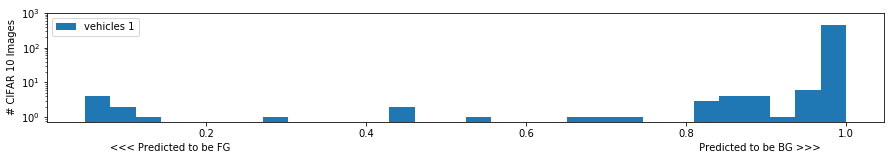

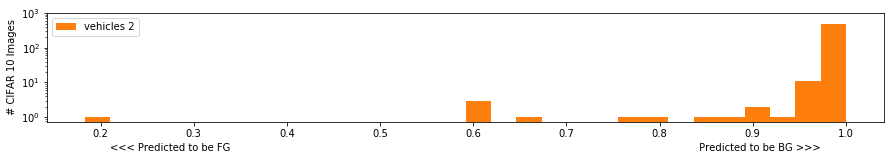

In [26]:
for i, label in enumerate(cifar100_superclasses.keys()):
    i = i + 2
    
    data = softmax_outputs[:,1][test_labels == i]
    
    plt.figure(figsize=(15, 2))

    plt.hist(data, bins=30, color=colors[i%10], log=True, label=[label])
    plt.xlabel('<<< Predicted to be FG' + " "*150 + 'Predicted to be BG >>>')
    plt.ylabel('# CIFAR 10 Images')
#     plt.title(label)
    plt.yticks([10**x for x in range(4)])
    plt.legend()
    plt.show()

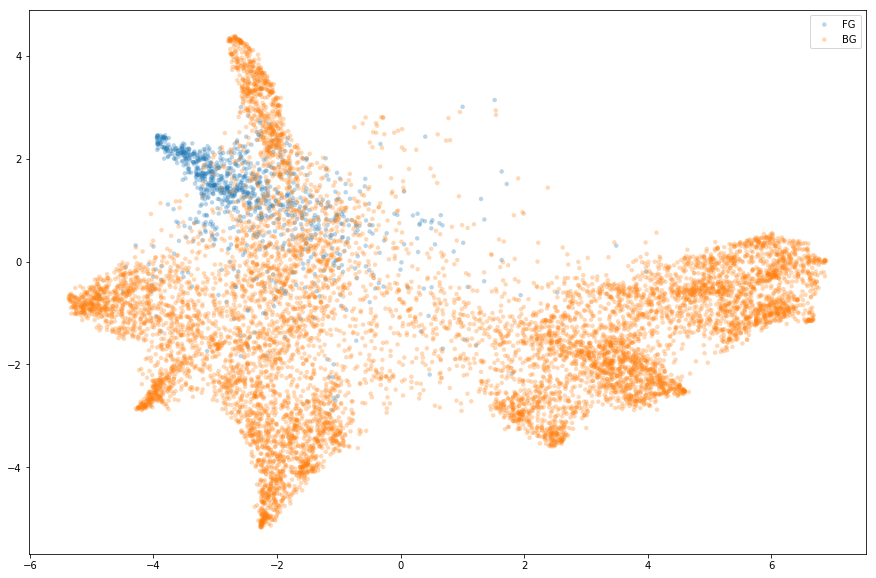

In [27]:
fig, ax = plt.subplots(figsize=(15, 10))
labels = ['FG', 'BG']

for label in range(len(labels)):
    x = embedding[:,0][test_labels == label]
    y = embedding[:,1][test_labels == label]
    ax.scatter(x, y, c=colors[label], s=20, label=labels[label], alpha=0.3, edgecolors='none')

ax.legend()
plt.show()

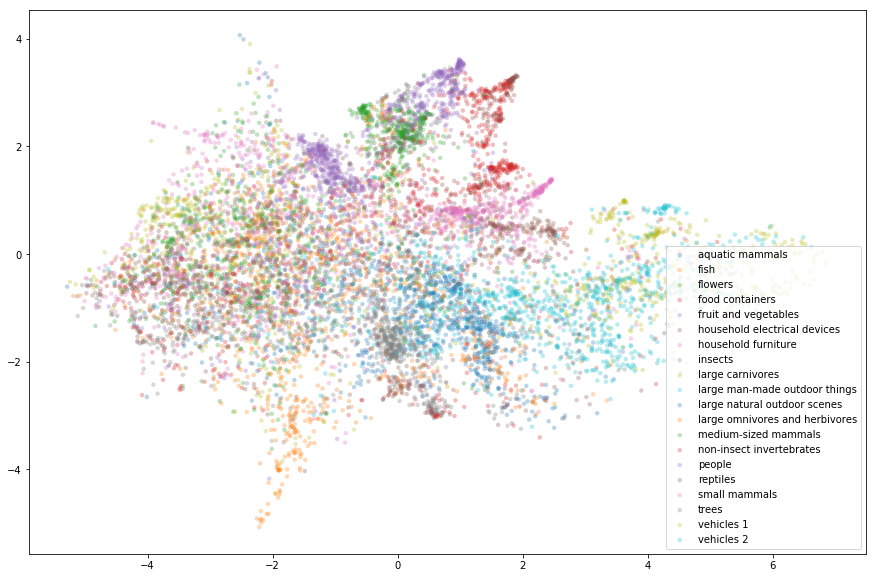

In [28]:
fig, ax = plt.subplots(figsize=(15, 10))
labels = list(cifar100_superclasses.keys())

for i, label in enumerate(labels):
    x = embedding[:,0][test_labels == i+2]
    y = embedding[:,1][test_labels == i+2]
    ax.scatter(x, y, s=20, label=labels[i], alpha=0.3, edgecolors='none', cmap='tab20')

ax.legend()
plt.show()

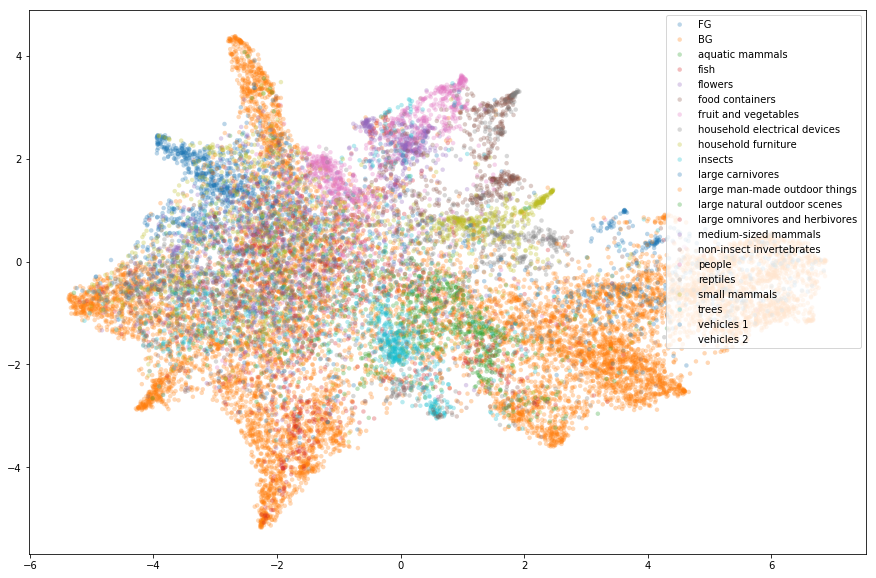

In [29]:
fig, ax = plt.subplots(figsize=(15, 10))
labels = ['FG', 'BG'] + list(cifar100_superclasses.keys())

for i, label in enumerate(labels):
    x = embedding[:,0][test_labels == i]
    y = embedding[:,1][test_labels == i]
    ax.scatter(x, y, s=20, label=labels[i], alpha=0.3, edgecolors='none', cmap='tab20')

ax.legend()
plt.show()

# next steps

- Talk to Matt to confirm that MD implemented correctly
- Implement MC-Dropout to see if we can prevent more OOD being classified as FG
- Try other methods to either improve precision of FG classification (OOD should be BG) or separate OOD from BG and FG
- Look at zero-shot learning as method for determining new classes for OOD images
- Read fishy-scapes paper
- Consider using soft-sampling for robust object detection technique for training object detector